# **Importing Libraries**

In [13]:
import os
import pandas as pd
import numpy as np
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Dense, Dropout,
    Bidirectional, GlobalAveragePooling1D, Attention,
    Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# **Load Dataset**

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bahushruth/legalclausedataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/bahushruth/legalclausedataset/versions/1


In [15]:
import pandas as pd
df = pd.read_csv(os.path.join(path, "acceleration.csv"))
df.head()

,clause_text,clause_type
0,Acceleration. On and at any time after the occ...,acceleration
1,Acceleration. (a) If an Event of Default with ...,acceleration
2,Acceleration. If an Event of Default (other th...,acceleration
3,Acceleration. If an Event of Default with resp...,acceleration
4,Acceleration. If any Default described in Sect...,acceleration


# **Merge & Clean Data**

In [16]:
all_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".csv")]
dfs = []
for f in all_files:
    d = pd.read_csv(f)
    d["category"] = os.path.basename(f).replace(".csv", "")
    dfs.append(d)
data = pd.concat(dfs, ignore_index=True)

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

data["clause_text"] = data["clause_text"].apply(clean_text)

# **Make clause pairs**

In [17]:
same_pairs = []
diff_pairs = []
for cat in data["category"].unique():
    dcat = data[data["category"] == cat]
    for i in range(len(dcat) - 1):
        same_pairs.append((dcat.iloc[i]["clause_text"], dcat.iloc[i + 1]["clause_text"], 1))

cats = data["category"].unique()
for i in range(len(cats) - 1):
    d1 = data[data["category"] == cats[i]]
    d2 = data[data["category"] == cats[i + 1]]
    for j in range(min(len(d1), len(d2))):
        diff_pairs.append((d1.iloc[j]["clause_text"], d2.iloc[j]["clause_text"], 0))

df_pairs = pd.DataFrame(same_pairs + diff_pairs, columns=["clause1", "clause2", "label"])
print("Total pairs:", len(df_pairs))

Total pairs: 283919


# **Text Tokenization**

In [18]:
texts = list(df_pairs["clause1"]) + list(df_pairs["clause2"])
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

maxlen = 50
X1 = pad_sequences(tokenizer.texts_to_sequences(df_pairs["clause1"]), maxlen=maxlen, padding="post")
X2 = pad_sequences(tokenizer.texts_to_sequences(df_pairs["clause2"]), maxlen=maxlen, padding="post")
y = np.array(df_pairs["label"])

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42, stratify=y
)

# **Baseline Model 1: Siamese BiLSTM**

In [19]:
embedding_dim = 128

def build_siamese_bilstm():
    inp = Input(shape=(maxlen,))
    x = Embedding(10000, embedding_dim, trainable=True)(inp)
    x = Bidirectional(LSTM(64, return_sequences=False))(x)
    x = Dense(64, activation="relu")(x)
    return Model(inp, x)

encoder = build_siamese_bilstm()
in1, in2 = Input(shape=(maxlen,)), Input(shape=(maxlen,))
v1, v2 = encoder(in1), encoder(in2)
merged = Lambda(lambda x: K.abs(x[0] - x[1]))([v1, v2])
out = Dense(1, activation="sigmoid")(merged)
model1 = Model([in1, in2], out)
model1.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model1.summary()

start_time = time.time()
hist1 = model1.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.2, epochs=10, batch_size=128, verbose=1
)
end_time = time.time()

train_time_lstm = end_time - start_time

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_2        │ (None, 64)        │  1,387,072 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ functional_2[0][… │
│                     │                   │            │ functional_2[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,387,137 (5.29 MB)

 Trainable params: 1,387,137 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.6484 - loss: 0.6082 - val_accuracy: 0.7809 - val_loss: 0.4561
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8062 - loss: 0.4147 - val_accuracy: 0.8164 - val_loss: 0.3999
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.8547 - loss: 0.3325 - val_accuracy: 0.8328 - val_loss: 0.3679
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.8876 - loss: 0.2697 - val_accuracy: 0.8418 - val_loss: 0.3618
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9131 - loss: 0.2154 - val_accuracy: 0.8505 - val_loss: 0.3678
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.9344 - loss: 0.1699 - val_accuracy: 0.8557 - val_loss: 0.3840
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9528 - loss: 0.1302 - val_accuracy: 0.8596 - val_loss: 0.4053
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.9647 -

# **Baseline Model 2: Attention Encoder**

In [20]:
def build_attention_encoder():
    inp = Input(shape=(maxlen,))
    x = Embedding(10000, embedding_dim, trainable=True)(inp)
    att = Attention()([x, x])
    x = GlobalAveragePooling1D()(att)
    x = Dense(64, activation="relu")(x)
    return Model(inp, x)

enc2 = build_attention_encoder()
in1, in2 = Input(shape=(maxlen,)), Input(shape=(maxlen,))
v1, v2 = enc2(in1), enc2(in2)
merged = Concatenate()([v1, v2, Lambda(lambda x: K.abs(x[0] - x[1]))([v1, v2])])
out = Dense(1, activation="sigmoid")(merged)
model2 = Model([in1, in2], out)
model2.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
model2.summary()

start_time = time.time()
hist2 = model2.fit(
    [X1_train, X2_train], y_train,
    validation_split=0.2, epochs=10, batch_size=128, verbose=1
)
end_time = time.time()

train_time_encoder = end_time - start_time

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 64)        │  1,288,256 │ input_layer_7[0]… │
│ (Functional)        │                   │            │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 64)        │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ functional_4[0][… │
│ (Concatenate)       │                   │            │ functional_4[1][… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        193 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,288,449 (4.92 MB)

 Trainable params: 1,288,449 (4.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6486 - loss: 0.6065 - val_accuracy: 0.7963 - val_loss: 0.4398
Epoch 2/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8133 - loss: 0.4081 - val_accuracy: 0.8230 - val_loss: 0.3941
Epoch 3/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8561 - loss: 0.3357 - val_accuracy: 0.8451 - val_loss: 0.3547
Epoch 4/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8870 - loss: 0.2748 - val_accuracy: 0.8586 - val_loss: 0.3327
Epoch 5/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9066 - loss: 0.2323 - val_accuracy: 0.8639 - val_loss: 0.3304
Epoch 6/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9226 - loss: 0.1966 - val_accuracy: 0.8660 - val_loss: 0.3365
Epoch 7/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9374 - loss: 0.1673 - val_accuracy: 0.8672 - val_loss: 0.3444
Epoch 8/10
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9478 - loss: 0.1414 -

# **Evaluation**

In [21]:
def evaluate_model(model, X1_test, X2_test, y_test, name="Model"):
    y_pred = model.predict([X1_test, X2_test])
    y_label = (y_pred > 0.5).astype(int)
    metrics = {
        "Accuracy": accuracy_score(y_test, y_label),
        "Precision": precision_score(y_test, y_label),
        "Recall": recall_score(y_test, y_label),
        "F1": f1_score(y_test, y_label),
        "ROC-AUC": roc_auc_score(y_test, y_pred)
    }
    print(f"\n--- {name} Results ---")
    for k, v in metrics.items():
        print(f"{k}: {v:.3f}")
    return y_pred, metrics

y_pred1, metrics1 = evaluate_model(model1, X1_test, X2_test, y_test, "BiLSTM Siamese")
y_pred2, metrics2 = evaluate_model(model2, X1_test, X2_test, y_test, "Attention Encoder")


1775/1775 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

--- BiLSTM Siamese Results ---
Accuracy: 0.862
Precision: 0.876
Recall: 0.861
F1: 0.869
ROC-AUC: 0.931
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

--- Attention Encoder Results ---
Accuracy: 0.868
Precision: 0.873
Recall: 0.879
F1: 0.876
ROC-AUC: 0.940


# **Correctly & Incorrectly matched legal clauses**

In [22]:
y_pred_label1 = (y_pred1 > 0.5).astype(int).flatten()
y_pred_label2 = (y_pred2 > 0.5).astype(int).flatten()

# DataFrame with clauses, true labels, predictions
df_results = pd.DataFrame({
    "Clause1": df_pairs.iloc[X1_test.indices if hasattr(X1_test,'indices') else np.arange(len(X1_test))]['clause1'].values,
    "Clause2": df_pairs.iloc[X1_test.indices if hasattr(X1_test,'indices') else np.arange(len(X2_test))]['clause2'].values,
    "True_Label": y_test,
    "Pred_BiLSTM": y_pred_label1,
    "Pred_Attention": y_pred_label2
})

# Correctly predicted
correct_bilstm = df_results[df_results["True_Label"] == df_results["Pred_BiLSTM"]].sample(5)
print("Correctly predicted by BiLSTM")
for idx, row in correct_bilstm.iterrows():
    print(f"\nClause 1: {row['Clause1']}")
    print(f"Clause 2: {row['Clause2']}")
    print(f"Label: {row['True_Label']} Pred: {row['Pred_BiLSTM']}")

# Incorrectly predicted
incorrect_bilstm = df_results[df_results["True_Label"] != df_results["Pred_BiLSTM"]].sample(5)
print("\nIncorrectly predicted by BiLSTM")
for idx, row in incorrect_bilstm.iterrows():
    print(f"\nClause 1: {row['Clause1']}")
    print(f"Clause 2: {row['Clause2']}")
    print(f"Label: {row['True_Label']} Pred: {row['Pred_BiLSTM']}")


Correctly predicted by BiLSTM

Clause 1: judgments any money judgment writ of attachment or similar process is filed against borrower any subsidiary of borrower or any guarantor or any of their respective property
Clause 2: judgments a final judgment obtained against a relevant transaction party is conclusive as against each guarantor
Label: 0 Pred: 0

Clause 1: certain definitions capitalized terms used in this agreement and not otherwise defined shall have the following respective meanings
Clause 2: certain definitions as used herein the term registrable security means the conversion shares warrant shares default warrant shares and the distribution shares until i the registration statement as defined below has been declared effective by the securities and exchange commission the commission and all securities have been disposed of pursuant to the registration statement ii all securities have been sold under circumstances under which all of the applicable conditions of rule 144 rule 14

In [23]:
# Correctly predicted
correct_attention = df_results[df_results["True_Label"] == df_results["Pred_Attention"]].sample(5)
print("=== Correctly predicted by Attention ===")
for idx, row in correct_attention.iterrows():
    print(f"\nClause 1: {row['Clause1']}")
    print(f"Clause 2: {row['Clause2']}")
    print(f"Label: {row['True_Label']} Pred: {row['Pred_Attention']}")

# Incorrectly predicted
incorrect_attention = df_results[df_results["True_Label"] != df_results["Pred_Attention"]].sample(5)
print("\n=== Incorrectly predicted by Attention ===")
for idx, row in incorrect_attention.iterrows():
    print(f"\nClause 1: {row['Clause1']}")
    print(f"Clause 2: {row['Clause2']}")
    print(f"Label: {row['True_Label']} Pred: {row['Pred_Attention']}")


=== Correctly predicted by Attention ===

Clause 1: investment company act neither the company nor the operating partnership is required or upon the issuance and sale of the securities as herein contemplated and the application of the net proceeds therefrom as described in the registration statement and the prospectus will be required to register as an investment company under the investment company act
Clause 2: investment company act the company is not and after giving effect to the offering and sale of the securities as herein contemplated and the application of the proceeds thereof as described in the pricing prospectus will not be an investment company as such term is defined in the investment company act of 1940 as amended
Label: 1 Pred: 1

Clause 1: purchase and sale a subject to the terms and conditions set forth herein and in schedule iii and in reliance upon the representations and warranties herein contained the guarantor and the company agree to cause the trustee to sell to

# **Visualization**

**Training Curves**

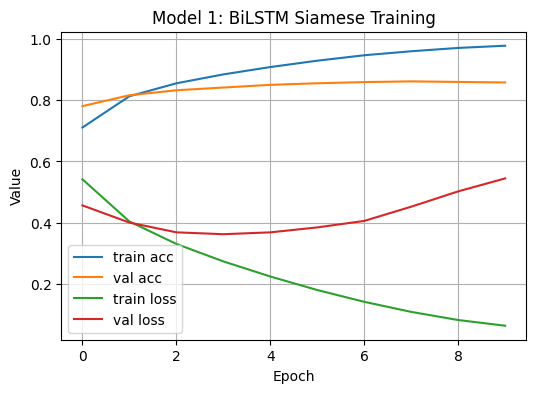

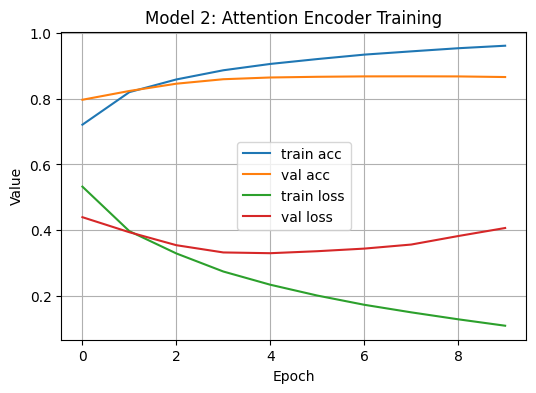

In [24]:
def plot_training(history, title):
    plt.figure(figsize=(6,4))
    plt.plot(history.history["accuracy"], label="train acc")
    plt.plot(history.history["val_accuracy"], label="val acc")
    plt.plot(history.history["loss"], label="train loss")
    plt.plot(history.history["val_loss"], label="val loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training(hist1, "Model 1: BiLSTM Siamese Training")
plot_training(hist2, "Model 2: Attention Encoder Training")

**ROC Curves**

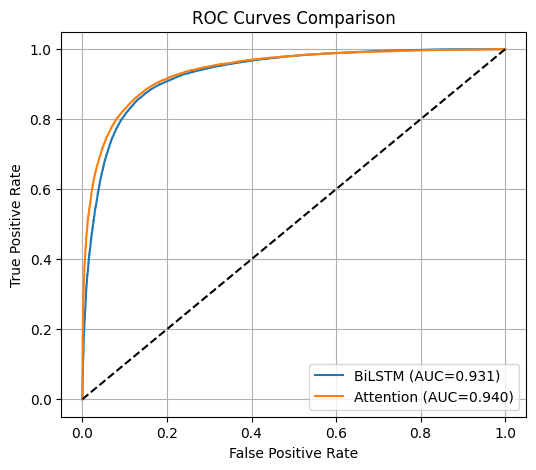

In [25]:
def plot_roc(y_true, y_score1, y_score2):
    fpr1, tpr1, _ = roc_curve(y_true, y_score1)
    fpr2, tpr2, _ = roc_curve(y_true, y_score2)
    plt.figure(figsize=(6,5))
    plt.plot(fpr1, tpr1, label=f"BiLSTM (AUC={roc_auc_score(y_true, y_score1):.3f})")
    plt.plot(fpr2, tpr2, label=f"Attention (AUC={roc_auc_score(y_true, y_score2):.3f})")
    plt.plot([0,1],[0,1],"k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc(y_test, y_pred1, y_pred2)

**Training times**

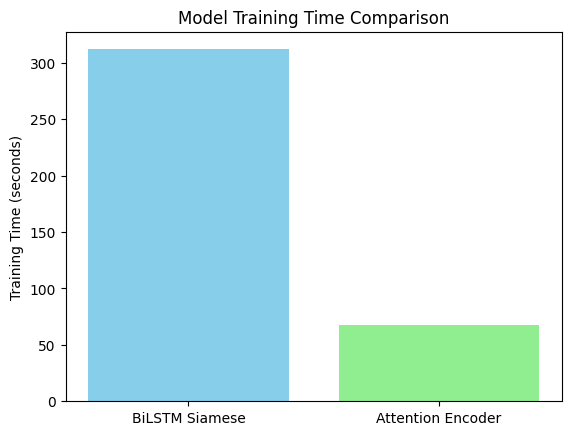

In [26]:
import matplotlib.pyplot as plt

times = [train_time_lstm, train_time_encoder]
labels = ['BiLSTM Siamese', 'Attention Encoder']

plt.bar(labels, times, color=['skyblue', 'lightgreen'])
plt.ylabel("Training Time (seconds)")
plt.title("Model Training Time Comparison")
plt.show()


# **Comparative Analysis**

In [28]:
print("\nComparison Table")
print(f"{'Metric':<15}{'BiLSTM':>12}{'Attention':>15}")
print("-" * 42)

for m in metrics1.keys():
    print(f"{m:<15}{metrics1[m]:>12.3f}{metrics2[m]:>15.3f}")

print(f"{'Training Time (s)':<15}{train_time_lstm:>12.2f}{train_time_encoder:>15.2f}")



Comparison Table
Metric               BiLSTM      Attention
------------------------------------------
Accuracy              0.862          0.868
Precision             0.876          0.873
Recall                0.861          0.879
F1                    0.869          0.876
ROC-AUC               0.931          0.940
Training Time (s)      312.06          67.53
